# Event-driven continuous-time multiagent model

The spatial rock-paper-scissors (RPS) is an ABM with the following rules:

+ Agents can be any of three "kinds": Rock, Paper, or Scissors.
+ Agents live in a 2D periodic grid space allowing only one agent per cell.
+ When an agent activates, it can do one of three actions:
    1. Attack: choose a random nearby agent and attack it. If the agent loses the RPS game it gets removed.
    2. Move: choose a random nearby position. If it is empty move to it, otherwise swap positions with the agent there.
    3. Reproduce: choose a random empty nearby position (if any exist). Generate there a new agent of the same type.

In [1]:
using Agents
using Random
using LinearAlgebra
using Base64
using Agents.DataFrames
using CairoMakie
CairoMakie.activate!(px_per_unit = 1.0)

The helper function is adapted from `Agents.abmvideo` and correctly displays animations in Jupyter notebooks

In [2]:
function abmvio(model;
    dt = 1, framerate = 30, frames = 300, title = "", showstep = true,
    figure = (size = (600, 600),), axis = NamedTuple(),
    recordkwargs = (compression = 23, format ="mp4"), kwargs...
)
    # title and steps
    abmtime_obs = Observable(abmtime(model))
    if title ≠ "" && showstep
        t = lift(x -> title*", time = "*string(x), abmtime_obs)
    elseif showstep
        t = lift(x -> "time = "*string(x), abmtime_obs)
    else
        t = title
    end

    axis = (title = t, titlealign = :left, axis...)
    # First frame
    fig, ax, abmobs = abmplot(model; add_controls = false, warn_deprecation = false, figure, axis, kwargs...)
    resize_to_layout!(fig)
    # Animation
    Makie.Record(fig; framerate, recordkwargs...) do io
        for j in 1:frames-1
            recordframe!(io)
            Agents.step!(abmobs, dt)
            abmtime_obs[] = abmtime(model)
        end
        recordframe!(io)
    end
end

abmvio (generic function with 1 method)

Define rock, paper, and scissors (RPS) agents. One can use `variant(agent)` to see the agent type.

In [3]:
@agent struct Rock(GridAgent{2}) end
@agent struct Paper(GridAgent{2}) end
@agent struct Scissors(GridAgent{2}) end
@multiagent RPS(Rock, Paper, Scissors)

Agent actions

In [4]:
function attack!(agent, model)
    # Randomly pick a nearby agent
    contender = random_nearby_agent(agent, model)
    isnothing(contender) && return # do nothing if there isn't anyone nearby
    # The attacking action will be dispatched to the following methods.
    attack!(variant(agent), variant(contender), contender, model)
    return nothing
end

attack!(::AbstractAgent, ::AbstractAgent, contender, model) = nothing
attack!(::Rock, ::Scissors, contender, model) = remove_agent!(contender, model)
attack!(::Scissors, ::Paper, contender, model) = remove_agent!(contender, model)
attack!(::Paper, ::Rock, contender, model) = remove_agent!(contender, model)

attack! (generic function with 5 methods)

Move actions use `move_agent!` and `swap_agents!` functions

In [5]:
function move!(agent, model)
    rand_pos = random_nearby_position(agent.pos, model)
    if isempty(rand_pos, model)
        move_agent!(agent, rand_pos, model)
    else
        occupant_id = id_in_position(rand_pos, model)
        occupant = model[occupant_id]
        swap_agents!(agent, occupant, model)
    end
    return nothing
end

move! (generic function with 1 method)

Reproduce actions use `replicate!` function

In [6]:
function reproduce!(agent, model)
    pos = random_nearby_position(agent, model, 1, pos -> isempty(pos, model))
    isnothing(pos) && return
    # pass target position as a keyword argument
    replicate!(agent, model; pos)
    return nothing
end

reproduce! (generic function with 1 method)

Defining the propensity ("rate" in Gillespie stochastic simulations) and timing of the events

In [7]:
attack_propensity = 1.0
movement_propensity = 0.5
reproduction_propensity(agent, model) = cos(abmtime(model))^2

reproduction_propensity (generic function with 1 method)

Register events with `AgentEvent`

In [8]:
attack_event = AgentEvent(action! = attack!, propensity = attack_propensity)
reproduction_event = AgentEvent(action! = reproduce!, propensity = reproduction_propensity)

Agents.AgentEvent{typeof(Main.var"##229".reproduce!), typeof(Main.var"##229".reproduction_propensity), DataType, typeof(Agents.exp_propensity)}(Main.var"##229".reproduce!, Main.var"##229".reproduction_propensity, Agents.AbstractAgent, Agents.exp_propensity)

We want a different distribution other than exponential distribution for movement time

In [9]:
function movement_time(agent, model, propensity)
    # Make time around 1
    t = 0.1 * randn(abmrng(model)) + 1
    return clamp(t, 0, Inf)
end

movement_time (generic function with 1 method)

Also rocks do not move

In [10]:
movement_event = AgentEvent(
    action! = move!, propensity = movement_propensity,
    types = Union{Scissors, Paper}, timing = movement_time
)

Agents.AgentEvent{typeof(Main.var"##229".move!), Float64, Union, typeof(Main.var"##229".movement_time)}(Main.var"##229".move!, 0.5, Union{Main.var"##229".Paper, Main.var"##229".Scissors}, Main.var"##229".movement_time)

Collect all events

In [11]:
events = (attack_event, reproduction_event, movement_event)

(Agents.AgentEvent{typeof(Main.var"##229".attack!), Float64, DataType, typeof(Agents.exp_propensity)}(Main.var"##229".attack!, 1.0, Agents.AbstractAgent, Agents.exp_propensity), Agents.AgentEvent{typeof(Main.var"##229".reproduce!), typeof(Main.var"##229".reproduction_propensity), DataType, typeof(Agents.exp_propensity)}(Main.var"##229".reproduce!, Main.var"##229".reproduction_propensity, Agents.AbstractAgent, Agents.exp_propensity), Agents.AgentEvent{typeof(Main.var"##229".move!), Float64, Union, typeof(Main.var"##229".movement_time)}(Main.var"##229".move!, 0.5, Union{Main.var"##229".Paper, Main.var"##229".Scissors}, Main.var"##229".movement_time))

Model function `EventQueueABM` for an event-driven ABM

In [12]:
const alltypes = (Rock, Paper, Scissors)

function initialize_rps(; n = 100, nx = n, ny = n, seed = 42)
    space = GridSpaceSingle((nx, ny))
    rng = Xoshiro(seed)
    model = EventQueueABM(RPS, events, space; rng, warn = false)
    for p in positions(model)
        # Randomly assign one of the agent
        type = rand(abmrng(model), alltypes)
        add_agent!(p, constructor(RPS, type), model)
    end
    return model
end

initialize_rps (generic function with 1 method)

Have a look at the event queue

In [13]:
model = initialize_rps()
abmqueue(model)

DataStructures.BinaryHeap{Pair{Tuple{Int64, Int64}, Float64}, Base.Order.By{typeof(last), DataStructures.FasterForward}}(Base.Order.By{typeof(last), DataStructures.FasterForward}(last, DataStructures.FasterForward()), [(6080, 1) => 2.9790681020079457e-6, (3987, 1) => 0.0003364593569030146, (6221, 2) => 0.0004887948187761659, (8424, 1) => 0.0006778319693496694, (5035, 1) => 0.0012044922191219774, (7014, 2) => 0.0005771225059120387, (3301, 2) => 0.0011396494447446436, (2505, 1) => 0.0014309955844005063, (5041, 2) => 0.001449028423933035, (5539, 2) => 0.0024520873429744127  …  (9990, 1) => 1.0666363792018059, (9992, 2) => 0.7429399475482082, (9993, 1) => 1.9378465659189394, (4997, 1) => 1.7907183401427267, (2496, 1) => 0.5304394096759053, (2499, 1) => 2.7442278746073216, (4998, 3) => 1.0804360033507288, (4999, 1) => 5.80807081086072, (9998, 1) => 0.9433255253597445, (1250, 3) => 1.258669914970242])

The time in `EventQueueABM` is continuous, so we can pass real-valued time.

In [14]:
step!(model, 123.456)
nagents(model)

9664

The `step!` function also accepts a terminating condition.

In [15]:
function terminate(model, t)
    willterm = length(allagents(model)) < 5000
    return willterm || (t > 1000.0)
end

model = initialize_rps()
step!(model, terminate)
abmtime(model)

1000.0000829102537

## Data collection
- adata: aggregated data to extract information from the execution stats
- adf: agent data frame

In [16]:
model = initialize_rps()
adata = [(a -> variantof(a) === X, count) for X in alltypes]

adf, mdf = run!(model, 100.0; adata, when = 0.5, dt = 0.01)
adf[1:10, :]

10×4 DataFrame
 Row │ time     count_#35_X=Main.var"##229".Rock  count_#35_X=Main.var"##229". ⋯
     │ Float64  Int64                             Int64                        ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │    0.0                               3293                               ⋯
   2 │    0.5                               3226
   3 │    1.0                               3213
   4 │    1.5                               3165
   5 │    2.0                               3088                               ⋯
   6 │    2.51                              2971
   7 │    3.02                              2981
   8 │    3.53                              3097
   9 │    4.04                              3180                               ⋯
  10 │    4.55                              3237
                                                               2 columns omitted

## Visualize population change

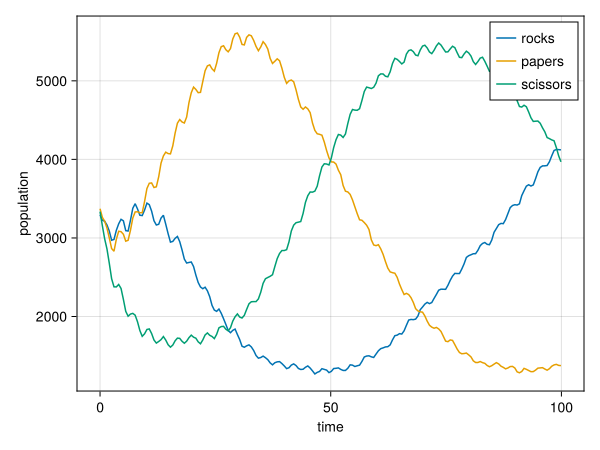

In [17]:
tvec = adf[!, :time]  ## time as x axis
populations = adf[:, Not(:time)]  ## agents as data
alabels = ["rocks", "papers", "scissors"]

fig = Figure();
ax = Axis(fig[1,1]; xlabel = "time", ylabel = "population")
for (i, l) in enumerate(alabels)
    lines!(ax, tvec, populations[!, i]; label = l)
end
axislegend(ax)
fig

## Visualize agent distribution

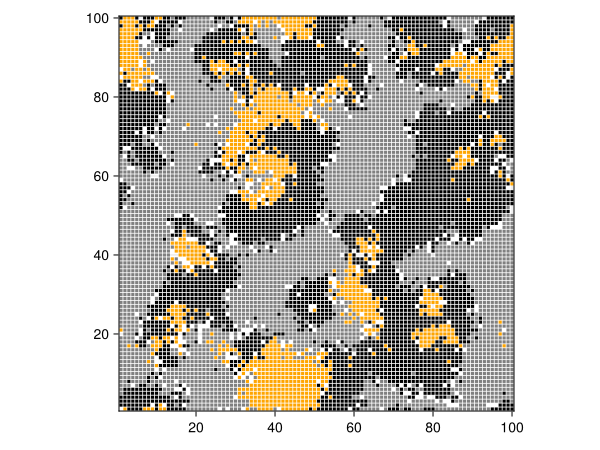

In [18]:
const colormap = Dict(Rock => "black", Scissors => "gray", Paper => "orange")
agent_color(agent) = colormap[variantof(agent)]
plotkw = (agent_color, agent_marker = :rect, agent_size = 5)
fig, ax, abmobs = abmplot(model; plotkw...)

fig

# Animation

In [19]:
model = initialize_rps()
vio = abmvio( model;
    dt = 0.5, frames = 300,
    title = "Rock Paper Scissors (event based)",
    plotkw...,
)

save("rps.mp4", vio)
vio |> display

Makie.VideoStream(Base.PipeEndpoint(RawFD(4294967295) closed, 0 bytes waiting), Process(setenv(`/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin/ffmpeg -y -loglevel quiet -threads 4 -framerate 30 -pixel_format rgb24 -f rawvideo -s:v 600x600 -r 30 -i pipe:0 -vf vflip -profile:v high422 -crf 23 -preset slow -c:v libx264 -pix_fmt yuv420p -an '/tmp/jl_JOCZw9/##video#230.mp4'`,["JULIA_CI=true", "PATH=/home/runner/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/bin:/home/runner/.julia/artifacts/0ccc8805e5047cf9fbd848c4f7d4c15715aad7c9/bin:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/bin:/home/runner/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/bin:/home/runner/.julia/artifacts/c8a20a2030f10b70947d8d2a6bff7f8b5f343fe9/bin:/home/runner/.julia/artifacts/1cf7375e8ec1bbe1219934488737c12237ba2012/bin:/home/runner/.julia/artifacts/aa47becfd7dbea936fcdbe2abc2c5637739026df/bin:/home/runner/.julia/artifacts/00023f2f62a04af7531278ce1a689ff93800ffa1/bin:/home/runner/.julia/artifacts/c951fb23b5652def1dea483af7095a38f3b3cefd/bin:/home/runner/.julia/artifacts/fdb14f7b1bf6766687af4e3951c4d982cee66086/bin:/opt/hostedtoolcache/julia/1.10.6/x64/bin:/opt/hostedtoolcache/Python/3.12.7/x64/bin:/opt/hostedtoolcache/Python/3.12.7/x64:/snap/bin:/home/runner/.local/bin:/opt/pipx_bin:/home/runner/.cargo/bin:/home/runner/.config/composer/vendor/bin:/usr/local/.ghcup/bin:/home/runner/.dotnet/tools:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin", "DOTNET_SKIP_FIRST_TIME_EXPERIENCE=1", "GITHUB_RUN_NUMBER=449", "GITHUB_REF_NAME=main", "RUNNER_ARCH=X64", "STATS_PIP=false", "PERFLOG_LOCATION_SETTING=RUNNER_PERFLOG", "LD_LIBRARY_PATH=/home/runner/.julia/artifacts/f839432e3d2904a5c847b217ef0c0f489377ecc5/lib:/opt/hostedtoolcache/julia/1.10.6/x64/bin/../lib/julia:/home/runner/.julia/artifacts/0803f8d074309498cdf55effdb9c55bc3ef88dde/lib:/home/runner/.julia/artifacts/2ab21f29b30c228bd0e5215585f822730cad5a72/lib:/home/runner/.julia/artifacts/2def0eca464bd6d89ccac85338474402359d4930/lib:/home/runner/.julia/artifacts/d00220164876dea2cb19993200662745eed5e2db/lib:/home/runner/.julia/artifacts/0ccc8805e5047cf9fbd848c4f7d4c15715aad7c9/lib:/home/runner/.julia/artifacts/dc526f26fb179a3f68eb13fcbe5d2d2a5aa7eeac/lib:/home/runner/.julia/artifacts/c9fd7a94d3c09eac4f3ca94d21bf40ccf65eccf5/lib:/home/runner/.julia/artifacts/b757190a3c47fcb65f573f631fdd549b98fcf2e4/lib:/home/runner/.julia/artifacts/b3ddd583e7aec92a77cf5961fad01fd7063c1d40/lib:/home/runner/.julia/artifacts/7099954ffb0b6e1641832a06a08e479498ce479f/lib:/home/runner/.julia/artifacts/f92cfdafb94fa8c50330be3684c9aeb80bd14750/lib:/home/runner/.julia/artifacts/96bc7b9ddb319d1a051535c85184aa2bf42dbd8b/lib:/home/runner/.julia/artifacts/558980a93131f08be5335521b84e137ee3172296/lib:/home/runner/.julia/artifacts/d75cfbd8954fdbc933ebead40a9c8b91513c023a/lib:/home/runner/.julia/artifacts/9cfb24edca23321a2dcebb63b4e196181359ecd6/lib:/home/runner/.julia/artifacts/aae093c71ea1b1dc04c457afcae880d26c532115/lib:/home/runner/.julia/artifacts/bd965e3c7f9460155f06361da380c63fa0351ef6/lib:/home/runner/.julia/artifacts/060cf7829c3363638c29228ea4ab0bd033d8eab0/lib:/home/runner/.julia/artifacts/77d0e7c90e6a2fd6f2f8457bbb7b86ed86d140d9/lib:/home/runner/.julia/artifacts/1e69ef9fbf05e2896d3cb70eac8080c4d10f8696/lib:/home/runner/.julia/artifacts/e200b9737b27598b95b404cbc34e74f95b2bf5d0/lib:/home/runner/.julia/artifacts/a8e2d77aed043a035fd970326d8f070080efa8fa/lib:/home/runner/.julia/artifacts/6f98018cad6a09e91f90658f188c6be47e48a0c7/lib:/home/runner/.julia/artifacts/d4f3ff9736df0dda120f8dc1d27174b0d5696fb1/lib:/home/runner/.julia/artifacts/62c010876222f83fe8878bf2af0e362083d20ee3/lib:/home/runner/.julia/artifacts/75b657b876788e58671ab6b88e49019aa36b67cd/lib:/home/runner/.julia/artifacts/bd1f25e7053ebc00ee7d82f3c5ec4cf1e9a51e17/lib:/home/runner/.julia/artifacts/cf5d5f8a6109be3f9c460a39768f57a3e53ff11d/lib:/home/runner/.julia/ar

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*